In [21]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [22]:
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
            )
crime_df = pd.read_csv(data_path, header=1, index_col=False, skiprows=[0, 1, 2])
crime_df = crime_df.drop(crime_df.index[-3:])

#Clean up the column names
crime_df.columns=['City','Population', 'Violent crime', 'Murder', 'Rape revised', 'Rape legacy', 'Robbery', 
         'Aggravated assault','Property crime', 'Burglary', 'Larceny', 'Motor vehicle theft', 'Arson']
crime_df.tail(10)

,City,Population,Violent crime,Murder,Rape revised,Rape legacy,Robbery,Aggravated assault,Property crime,Burglary,Larceny,Motor vehicle theft,Arson
338,West Seneca Town,"44,821",35,1.000,nan,1,9,24,896,166,710,20,0.000
339,Whitehall Village,"2,604",6,0.000,nan,0,0,6,62,12,49,1,nan
340,White Plains,"57,559",78,1.000,nan,3,28,46,"1,232",77,"1,134",21,nan
341,Whitesboro Village,"3,733",4,0.000,nan,0,0,4,36,14,21,1,0.000
342,Whitestown Town,"9,141",0,0.000,nan,0,0,0,77,13,61,3,0.000
343,Woodbury Town,"10,685",3,0.000,nan,0,2,1,541,9,529,3,nan
344,Woodridge Village,829,7,0.000,nan,0,0,7,17,8,9,0,0.000
345,Woodstock Town,"5,931",2,0.000,nan,0,0,2,58,13,45,0,nan
346,Yonkers,"199,134","1,036",6.000,nan,25,390,615,"2,368",470,"1,662",236,10.000
347,Yorktown Town,"36,643",15,0.000,nan,0,2,13,334,45,287,2,nan


In [23]:
#Turn the Population strings into integers
crime_df['Population'] = crime_df['Population'].str.replace(',', '')
crime_df['Population'] = crime_df['Population'].astype(int)
#Turn the Robbery strings into integers
crime_df['Robbery'] = crime_df['Robbery'].str.replace(',', '')
crime_df['Robbery'] = crime_df['Robbery'].astype(int)
#Turn the Violent crime strings into integers
crime_df['Violent crime'] = crime_df['Violent crime'].str.replace(',', '')
crime_df['Violent crime'] = crime_df['Violent crime'].astype(int)
#Turn the Aggravated Assault strings into integers
crime_df['Aggravated assault'] = crime_df['Aggravated assault'].str.replace(',', '')
crime_df['Aggravated assault'] = crime_df['Aggravated assault'].astype(int)
#Turn the Property crime strings into integers
crime_df['Property crime'] = crime_df['Property crime'].str.replace(',', '')
crime_df['Property crime'] = crime_df['Property crime'].astype(int)
#Turn the Burglary strings into integers
crime_df['Burglary'] = crime_df['Burglary'].str.replace(',', '')
crime_df['Burglary'] = crime_df['Burglary'].astype(int)
#Turn the Larceny strings into integers
crime_df['Larceny'] = crime_df['Larceny'].str.replace(',', '')
crime_df['Larceny'] = crime_df['Larceny'].astype(int)
#Turn the Motor vehicle theft strings into integers
crime_df['Motor vehicle theft'] = crime_df['Motor vehicle theft'].str.replace(',', '')
crime_df['Motor vehicle theft'] = crime_df['Motor vehicle theft'].astype(int)

#Combine the Rape Scenarios into one category
crime_df['Rape legacy'] = crime_df['Rape legacy'].str.replace(',', '')
crime_df['Rape legacy'] = crime_df['Rape legacy'].astype(int)
crime_df['Rape revised'] = crime_df['Rape revised'].replace([None], 0).astype(int)
crime_df['Rape legacy'] = crime_df['Rape legacy'].replace([None], 0)
crime_df['Rape combined'] = crime_df['Rape revised'] + crime_df['Rape legacy']

crime_df['Arson'] = crime_df['Arson'].replace([None], 0).astype(int)

#Make Murder and Robbery binary
threshold = 1
crime_df['Murder binary'] = np.where(crime_df['Murder'] >= threshold, 1,0)
crime_df['Robbery binary'] = np.where(crime_df['Robbery'] >= threshold, 1, 0)

crime_df.head(10)

,City,Population,Violent crime,Murder,Rape revised,Rape legacy,Robbery,Aggravated assault,Property crime,Burglary,Larceny,Motor vehicle theft,Arson,Rape combined,Murder binary,Robbery binary
0,Adams Village,1861,0,0.000,0,0,0,0,12,2,10,0,0,0,0,0
1,Addison Town and Village,2577,3,0.000,0,0,0,3,24,3,20,1,0,0,0,0
2,Akron Village,2846,3,0.000,0,0,0,3,16,1,15,0,0,0,0,0
3,Albany,97956,791,8.000,0,30,227,526,4090,705,3243,142,0,30,1,1
4,Albion Village,6388,23,0.000,0,3,4,16,223,53,165,5,0,3,0,1
5,Alfred Village,4089,5,0.000,0,0,3,2,46,10,36,0,0,0,0,1
6,Allegany Village,1781,3,0.000,0,0,0,3,10,0,10,0,0,0,0,0
7,Amherst Town,118296,107,1.000,0,7,31,68,2118,204,1882,32,3,7,1,1
8,Amityville Village,9519,9,0.000,0,2,4,3,210,16,188,6,1,2,0,1
9,Amsterdam,18182,30,0.000,0,0,12,18,405,99,291,15,0,0,0,1


In [24]:
#Double Check there is no missing data

def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
print(crime_df.apply(num_missing, axis=0))

Missing values per column:
City                   0
Population             0
Violent crime          0
Murder                 0
Rape revised           0
Rape legacy            0
Robbery                0
Aggravated assault     0
Property crime         0
Burglary               0
Larceny                0
Motor vehicle theft    0
Arson                  0
Rape combined          0
Murder binary          0
Robbery binary         0
dtype: int64


In [25]:
#look at data for outliers
print(crime_df.describe())

       Population  Violent crime  Murder  Rape revised  Rape legacy   Robbery  \
count     348.000        348.000 348.000       348.000      348.000   348.000   
mean    40037.632        201.595   1.566         0.000        5.865    72.902   
std    450037.368       2815.269  18.304         0.000       60.425  1031.033   
min       526.000          0.000   0.000         0.000        0.000     0.000   
25%      3003.000          2.000   0.000         0.000        0.000     0.000   
50%      7233.500          6.000   0.000         0.000        0.000     1.000   
75%     18427.500         22.000   0.000         0.000        2.000     5.000   
max   8396126.000      52384.000 335.000         0.000     1112.000 19170.000   

       Aggravated assault  Property crime  Burglary    Larceny  \
count             348.000         348.000   348.000    348.000   
mean              121.261         792.606   119.684    637.017   
std              1706.132        7659.725   924.949   6346.054   
min   

In [26]:
#Let's Remove New York since it far outnumbers other data
crime_df = crime_df[crime_df.City != 'New York']

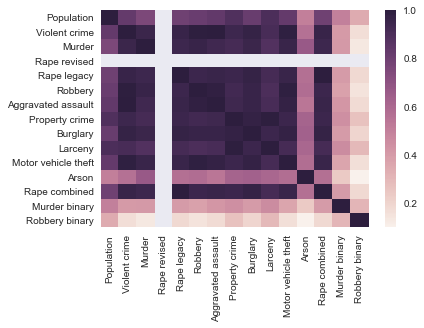

In [27]:
sns.heatmap(crime_df.corr())

In [28]:
# randomly create our training and test samples
msk = np.random.rand(len(crime_df)) < 0.8
train = crime_df[msk]
test = crime_df[~msk]
Y_train = train['Murder binary']
Y_test = test['Murder binary']
X_train = train.drop(['Murder binary', 'City'], axis=1)

In [29]:
X, y = X_train, Y_train
estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
selector.support_

array([False,  True,  True, False, False,  True, False, False, False,
       False, False,  True,  True, False], dtype=bool)

/Users/bryancorder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


NameError: name 'X_transform' is not defined

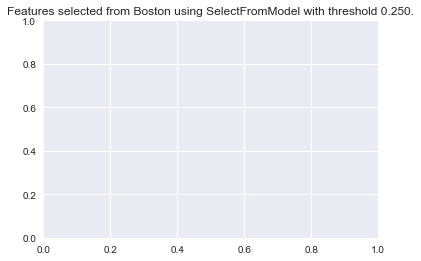

In [30]:
# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV()
X = X_train
y = Y_train
# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 2:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

# Plot the selected two features from X.
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()